# Import configuration and setup

In [1]:
from medulloblastoma.config import PROJ_ROOT, RAW_DATA_DIR, INTERIM_DATA_DIR, PROCESSED_DATA_DIR, EXTERNAL_DATA_DIR, MODELS_DIR, REPORTS_DIR, FIGURES_DIR
import os
import numpy as np
import pandas as pd
os.chdir(PROJ_ROOT)
from medulloblastoma.dataset import download_data, prepare_data
from medulloblastoma.features import main as preprocess_pipeline
from medulloblastoma.features import load_data
# Execute R script for GSE85217 data download
# ! Rscript {os.path.join(PROJ_ROOT, 'medulloblastoma','get_data.R')}

2025-12-13 12:56:10.132 | INFO     | medulloblastoma.config:<module>:11 - PROJ_ROOT path is: /home/edgar/VsCodeRepos/bitsxlamarato-medulloblastoma


# Prepare Data

In [2]:
# Download microarray gene expression data
download_data(save_path=RAW_DATA_DIR,remove_gz=True)

2025-12-13 10:38:14.901 | INFO     | medulloblastoma.dataset:download_data:77 - Downloading GSE85217 dataset from GEO...
Downloading: 100.0%
File downloaded successfully: /Users/arnaucasau/Documents/fib/Master/bitsxlamarato/bitsxlamarato-medulloblastoma/data/raw/GSE85217_M_exp_763_MB_SubtypeStudy_TaylorLab.txt.gz
2025-12-13 10:39:04.297 | INFO     | medulloblastoma.dataset:download_data:96 - Extracting compressed file...
2025-12-13 10:39:05.181 | SUCCESS  | medulloblastoma.dataset:download_data:101 - File extracted to: /Users/arnaucasau/Documents/fib/Master/bitsxlamarato/bitsxlamarato-medulloblastoma/data/raw/GSE85217_M_exp_763_MB_SubtypeStudy_TaylorLab.txt
2025-12-13 10:39:05.189 | INFO     | medulloblastoma.dataset:download_data:106 - Removed compressed .gz file


'/Users/arnaucasau/Documents/fib/Master/bitsxlamarato/bitsxlamarato-medulloblastoma/data/raw/GSE85217_M_exp_763_MB_SubtypeStudy_TaylorLab.txt'

In [4]:
# Structure data so that it is easier to handle
prepare_data(
    expression_file=os.path.join(RAW_DATA_DIR,'GSE85217_M_exp_763_MB_SubtypeStudy_TaylorLab.txt'),
    metadata_path = os.path.join(RAW_DATA_DIR,'GSE85217_metadata.csv'),
    save_path=RAW_DATA_DIR
)

2025-12-13 10:41:57.581 | INFO     | medulloblastoma.dataset:prepare_data:178 - Loading gene expression data from /Users/arnaucasau/Documents/fib/Master/bitsxlamarato/bitsxlamarato-medulloblastoma/data/raw/GSE85217_M_exp_763_MB_SubtypeStudy_TaylorLab.txt
2025-12-13 10:41:58.981 | INFO     | medulloblastoma.dataset:prepare_data:183 - Loaded expression data with shape: (21641, 767)
2025-12-13 10:41:58.982 | INFO     | medulloblastoma.dataset:prepare_data:188 - Extracting gene correspondence information...
2025-12-13 10:41:59.015 | INFO     | medulloblastoma.dataset:prepare_data:192 - Expression data after removing gene info: (21641, 763)
2025-12-13 10:41:59.015 | INFO     | medulloblastoma.dataset:prepare_data:195 - Loading metadata from /Users/arnaucasau/Documents/fib/Master/bitsxlamarato/bitsxlamarato-medulloblastoma/data/raw/GSE85217_metadata.csv
2025-12-13 10:41:59.023 | INFO     | medulloblastoma.dataset:prepare_data:200 - Loaded metadata with shape: (763, 37)
2025-12-13 10:41:59.02

('/Users/arnaucasau/Documents/fib/Master/bitsxlamarato/bitsxlamarato-medulloblastoma/data/raw/cavalli.csv',
 '/Users/arnaucasau/Documents/fib/Master/bitsxlamarato/bitsxlamarato-medulloblastoma/data/raw/cavalli_subgroups.csv')

# Preprocessing

Selecting genes that are lowly expressed, lowly variant, and outlier genes. We also check that there are no missing data.

Path to save data: /Users/arnaucasau/Documents/fib/Master/bitsxlamarato/bitsxlamarato-medulloblastoma/data/processed
2025-12-13 10:43:39.994 | INFO     | medulloblastoma.features:load_data:84 - Loading data from /Users/arnaucasau/Documents/fib/Master/bitsxlamarato/bitsxlamarato-medulloblastoma/data/raw/cavalli.csv
2025-12-13 10:43:41.251 | INFO     | medulloblastoma.features:load_data:87 - Loading metadata from /Users/arnaucasau/Documents/fib/Master/bitsxlamarato/bitsxlamarato-medulloblastoma/data/raw/cavalli_subgroups.csv
2025-12-13 10:43:41.254 | INFO     | medulloblastoma.features:load_data:91 - Initial data shape: (21641, 763), metadata shape: (763,)
2025-12-13 10:43:41.254 | INFO     | medulloblastoma.features:load_data:94 - Transposing data to match metadata dimensions
2025-12-13 10:43:41.254 | SUCCESS  | medulloblastoma.features:load_data:106 - Successfully loaded data: (763, 21641) samples × 21641 features
Shape of original data: (763, 21641)
null in data: 0
na in data: 0
Are a

<Figure size 700x500 with 0 Axes>

<Figure size 700x500 with 0 Axes>

<Figure size 700x500 with 0 Axes>

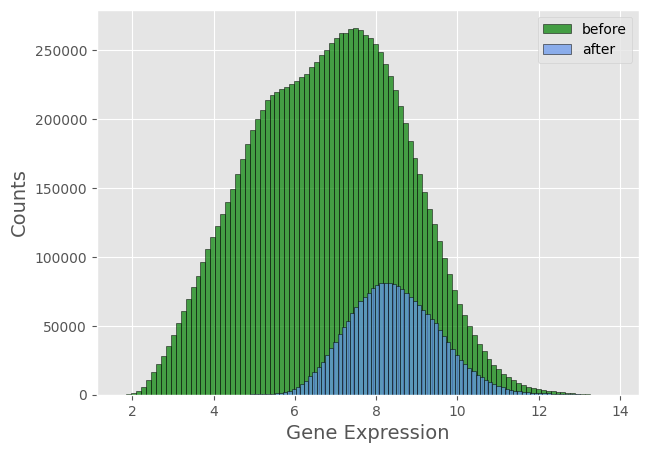

In [7]:
preprocess_pipeline(
    data_path=os.path.join(RAW_DATA_DIR,'cavalli.csv'),
    metadata_path=os.path.join(RAW_DATA_DIR,'cavalli_subgroups.csv'),
    save_path=PROCESSED_DATA_DIR,
    per=0.2,
    cutoff=0.1,
    alpha=0.05,
    outlier_method="other"
)

In [15]:
# Load preprocessed gene expression data
data=pd.read_csv(os.path.join(PROCESSED_DATA_DIR,'cavalli_statistical.csv'),index_col=0)

In [16]:
# Load metadata
metadata=pd.read_csv(os.path.join(RAW_DATA_DIR,'cavalli_subgroups.csv'),index_col=0).squeeze()
# Adapt names of groups of interests so they are shorter
metadata=metadata.map({'Group3':'G3','Group4':'G4'})
metadata.name = 'Subgroup'
# Select groups of interest in metedata
metadata_g3g4=metadata[metadata.isin(['G3','G4'])]
print(metadata.shape,metadata_g3g4.shape)

(763,) (470,)


In [17]:
# Select groups of interest in gene expression data
data_g3g4 = data.loc[metadata_g3g4.index]
print(data_g3g4.shape)

(470, 14403)


In [18]:
metadata.value_counts()

Subgroup
G4    326
G3    144
Name: count, dtype: int64

In [19]:
metadata_g3g4.value_counts()

Subgroup
G4    326
G3    144
Name: count, dtype: int64

In [10]:
# # Load final datasets
# data,metadata=load_data(
#     data_path=os.path.join(PROCESSED_DATA_DIR,'cavalli_maha.csv'),
#     metadata_path=os.path.join(PROCESSED_DATA_DIR,'g3g4_maha.csv')
# )
# print(data.shape,metadata.shape)

# UMAP Visualization of Preprocessed Data

In [20]:
from medulloblastoma.plots import plot_umap_binary

# Discrete color mapping for G3/G4 subtypes
dict_medulloblastoma = {
    'G3': 'red',  # Red for G3
    'G4': 'blue'   # Blue for G4
}

# Generate UMAP with discrete subtype coloring
plot_umap_binary(
    data=data_g3g4,
    clinical=metadata_g3g4,
    colors_dict=dict_medulloblastoma,
    n_components=2,
    save_fig=True,
    save_as="initial_medulloblastoma_umap",
    seed=2023,
    title="Medulloblastoma G3/G4 Gene Expression UMAP",
    marker_size=20
)

X_umap.shape (470, 2)
color_series.shape (470,)
len(all_patients) 470
color_series.loc[all_patients].values.shape (470,)
Saved UMAP plotly figure to: initial_medulloblastoma_umap.png
Saved UMAP plotly figure to: initial_medulloblastoma_umap.pdf
Saved UMAP plotly figure to: initial_medulloblastoma_umap.svg


# Model Training and Reconstruction

Using VAE...
The shape of the train data is (genes: features, patients: samples):  (14403, 610)
The shape of the test data is (genes: features, patients: samples):  (14403, 153)
Data will be transposed when calling DataLoader to get (samples, features) shape
DataLoader created
len(loader_test.dataset)= 153
DataLoader "normal" created
len(loader_test.dataset)= 153
len(loader_train.dataset)= 610
loader_test=	 <torch.utils.data.dataloader.DataLoader object at 0x705d1cbef250>
loader_train=	 <torch.utils.data.dataloader.DataLoader object at 0x705d1cc697f0>
loader_train.dataset.shape=	 torch.Size([610, 14403])
loader_test.dataset.shape=	 torch.Size([153, 14403])
Data Preprocessing successfully
input_dim =	 14403
mid_dim =	 1024
features =	 32
lr =	 0.0001
num_patients =	 763
num_classes =	 4
Starting Cycle  0


100%|██████████| 200/200 [00:25<00:00,  7.96it/s]


Starting Cycle  1


100%|██████████| 200/200 [00:24<00:00,  8.19it/s]


Starting Cycle  2


100%|██████████| 200/200 [00:24<00:00,  8.16it/s]


Trained VAE model saved as /home/edgar/VsCodeRepos/bitsxlamarato-medulloblastoma/models/20251213_CVAE_model/20251213_VAE_idim14403_md1024_feat32_lr0.0001.pth


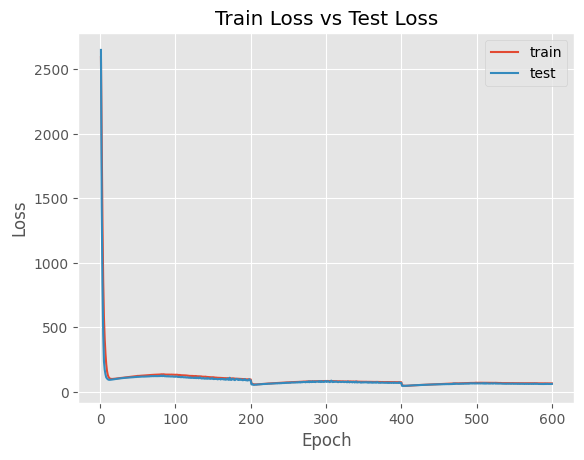

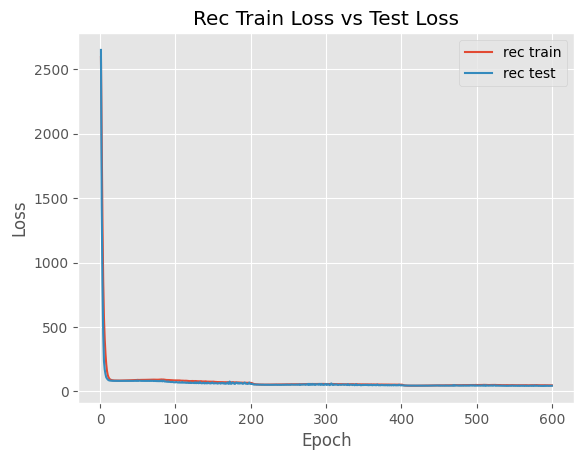

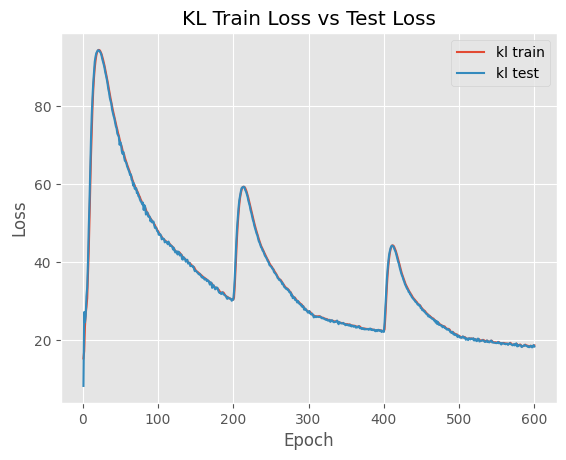

In [2]:
# BLANK SECTION FOR MODEL TRAINING
# This section will be implemented during the hackathon
# Plan for:
# - CVAE architecture definition
# - Training loop with G3/G4 labels
# - Hyperparameter optimization
# - Model evaluation and validation
# Clue: for architecture and hyperparameter optimization, you can use ax (see https://ax.dev/)

# Imports:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Custom functions:
from medulloblastoma.modeling.train_model import *

# Parameters:
ch_batch_size = 128
loss = 'mse'

# Cycle-annealing hyperparameters:
ch_epochs = 200
ch_cycles = 3
ch_width = 80
ch_reduction = 20
ch_beta = 1

# Number of stages of cancer; this will be used by the classifier in VAE_clinical
num_classes = 4

path_rnaseq = os.path.join(PROCESSED_DATA_DIR,'cavalli_statistical.csv')
path_clinical = os.path.join(RAW_DATA_DIR,'cavalli_subgroups.csv')
mid_dim = 1024
features = 32
lr = 1e-4

from datetime import datetime
today = datetime.today().strftime('%Y%m%d')

save_path = os.path.join(MODELS_DIR, f'{today}_CVAE')
save_model_path =os.path.join(MODELS_DIR, f'{today}_CVAE_model')

cvae = False

if cvae:
    from medulloblastoma.modeling.my_model import CVAE
    os.makedirs(save_path, exist_ok=True)
    model_type = 'CVAE'

    print('Using CVAE...')
    # Load data
    data_tensor, labels_onehot, loader_index_train, loader_index_test = load_data_cvae(
        path_rnaseq=path_rnaseq,
        path_clinical=path_clinical,
        batch_size=ch_batch_size
    )
    # print('type(data_tensor) =\t',type(data_tensor))
    # print('type(labels_onehot) =\t',type(labels_onehot))
    # Load model
    input_dim = data_tensor.shape[1]
    num_classes = labels_onehot.shape[1]
    # print('input_dim =\t',input_dim)
    # print('num_classes =\t',num_classes)
    chosen_model = CVAE(
        input_dim=input_dim,
        mid_dim=mid_dim,
        features=features,
        num_classes=num_classes,
    )


    # Train cyclically:
    loss, kl, rec, device = cyclical_training_cvae(
        save_path=save_model_path,
        model=chosen_model,
        loader_train_idx=loader_index_train,
        loader_test_idx=loader_index_test,
        data=data_tensor,
        labels=labels_onehot,
        epochs=ch_epochs,
        cycles=ch_cycles,
        beta=ch_beta,
        option=loss,
        learning_rate=lr,
        save_model=True
    )
    tr_l, tt_l = loss['train'], loss['test']
    tr_kl, tt_kl = kl['train'], kl['test']
    tr_r, tt_r = rec['train'], rec['test']

else:
    from medulloblastoma.modeling.my_model import *
    os.makedirs(save_path, exist_ok=True)
    model_type = 'VAE'
    print('Using VAE...')

    # Load data as tensor:
    train_data, train_loader, test_data, test_loader, loader_train_clinical, loader_test_clinical = data2tensor(
        path_rnaseq = path_rnaseq,
        path_clinical = path_clinical,
        batch_size = ch_batch_size,
        cvae = cvae,
        wsr = False,
        save_path=save_path,
    )

    input_dim = train_data.shape[0]
    num_patients = train_data.shape[1]+test_data.shape[1]
    print('Data Preprocessing successfully')

    print('input_dim =\t',input_dim)
    print('mid_dim =\t',mid_dim)
    print('features =\t',features)
    print('lr =\t',lr)
    print('num_patients =\t',num_patients)
    print('num_classes =\t',num_classes)
    # Initialize model:
    chosen_model = VAE(
        input_dim=input_dim,
        mid_dim=mid_dim,
        features=features,
    )
    # Create README:
    create_readme(
        today, path_rnaseq, path_clinical, save_path,
        ch_batch_size, input_dim, mid_dim, features,
        lr, loss, ch_epochs, ch_cycles, ch_width,
        ch_reduction, ch_beta, model_type,
        "standard"
    )
    (model_path, tr_l, tt_l, tr_kl, tt_kl, tr_r, tt_r, tt_dev) = cyclical_training(
        save_path=save_model_path,
        model=chosen_model,
        loader_train=train_loader,
        loader_test=test_loader,
        epochs=ch_epochs,
        cycles=ch_cycles,
        initial_width=ch_width,
        reduction=ch_reduction,
        beta=ch_beta,
        option=loss,
        learning_rate=lr,
        class_data_train=loader_train_clinical,
        class_data_test=loader_test_clinical,
        save_model=True,
        model_type=model_type,
        cvae=cvae,
    )

# Draw and save loss plots:
loss_plots(
    save_path=save_path,
    train_loss=tr_l,
    test_loss=tt_l,
    kl_loss_train=tr_kl,
    kl_loss_test=tt_kl,
    rec_loss_train=tr_r,
    rec_loss_test=tt_r,
)

# Final UMAP with Continuous Scoring

In [3]:
from medulloblastoma.plots import plot_umap_spectrum
import pandas as pd
import torch
import os
from sklearn.preprocessing import MinMaxScaler

In [4]:
def check_data(data):
    # check if data is DataFrame or numpy array
    if isinstance(data, pd.DataFrame):
        data = torch.tensor(data.values).float()
    elif isinstance(data, np.ndarray):
        data = torch.tensor(data).float()
    elif isinstance(data, torch.Tensor):
        data = data.float()
    else:
        raise ValueError("data is neither a pandas DataFrame, a numpy array, nor a torch tensor")
    return data

def apply_VAE(data,model_here,y=None):
    scaler = MinMaxScaler()
    scaler.fit(data)
    data2 = scaler.transform(data)
    
    with torch.no_grad():
        if y is None:
            data_latent, mu, logvar, z = model_here(torch.tensor(data2).float())
            data_vae = scaler.inverse_transform(data_latent)
        else:
            data_latent, mu, logvar, z = model_here(torch.tensor(data2).float(),torch.tensor(y).float())
            data_vae = scaler.inverse_transform(data_latent)

    return data_vae, mu, logvar, z, scaler

In [6]:
def load_model(model_path,model,hyperparams,seed=2023):
    # Importing the model:
    set_seed(seed)
    if model.__name__ == 'VAE':
        idim, md, feat = hyperparams
        model_vae = model(input_dim=idim, mid_dim=md, features=feat)  # Initialize the model
    elif model.__name__ == 'NetworkReconstruction':
        model_vae = model(hyperparams)
    else:
        raise ValueError('Model not recognized. Must be VAE or NetworkReconstruction')
    model_vae.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))  # Load the state dictionary
    model_vae.eval()  # Set the model to evaluation mode
    return model_vae

In [7]:
# For testing purposes, we assign a random score between 0 and 1 to each patient
# score=pd.Series(np.random.rand(470),name='score',index=metadata_g3g4.index)

data, _ = load_data(
    data_path=path_rnaseq,
    metadata_path=path_clinical
)

model_vae = load_model(
    model_path=model_path, 
    model=VAE,
    hyperparams=(input_dim, mid_dim, features), 
)
data_for_model = check_data(data=data)

decoded, _, _, z, scaler = apply_VAE(data=data_for_model, model_here=model_vae, y=None)
df_decoded = pd.DataFrame(decoded, index=data.index, columns=data.columns)
df_z = pd.DataFrame(z, index=data.index)

# Save the data
os.makedirs(save_path,exist_ok=True)
print('Saving data to:',save_path)
print('Saving latent space...')
df_z.to_csv(os.path.join(save_path,'z.csv'))
print('Done!')

2025-12-13 12:58:33.344 | INFO     | medulloblastoma.features:load_data:84 - Loading data from /home/edgar/VsCodeRepos/bitsxlamarato-medulloblastoma/data/processed/cavalli_statistical.csv
2025-12-13 12:58:35.510 | INFO     | medulloblastoma.features:load_data:87 - Loading metadata from /home/edgar/VsCodeRepos/bitsxlamarato-medulloblastoma/data/raw/cavalli_subgroups.csv
2025-12-13 12:58:35.513 | INFO     | medulloblastoma.features:load_data:91 - Initial data shape: (763, 14403), metadata shape: (763,)
2025-12-13 12:58:35.514 | SUCCESS  | medulloblastoma.features:load_data:106 - Successfully loaded data: (763, 14403) samples × 14403 features
Saving data to: /home/edgar/VsCodeRepos/bitsxlamarato-medulloblastoma/models/20251213_CVAE
Saving latent space...
Done!


In [23]:
plot_umap_spectrum(
    data=data_g3g4,
    clinical=score,  # Continuous scores instead of discrete labels
    colormap='RdBu',
    n_components=2,
    save_fig=True,
    save_as="final_scored_medulloblastoma_umap",
    seed=2023,
    title="Medulloblastoma G3/G4 Scores",
    marker_size=20
)

X_umap.shape (470, 2)
color_series.shape (470,)
color_series range: [0.003, 1.000]
len(all_patients) 470
Saved UMAP spectrum figure to: final_scored_medulloblastoma_umap.png
Saved UMAP spectrum figure to: final_scored_medulloblastoma_umap.pdf
Saved UMAP spectrum figure to: final_scored_medulloblastoma_umap.svg
